## Transformer-based Recommendation System

In [1]:
from comet_ml import Experiment
experiment = Experiment(api_key="ummagUWZ5eIZzmhPtFkA8oopu")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
[codecarbon INFO @ 18:46:01] [setup] RAM Tracking...
[codecarbon INFO @ 18:46:01] [setup] GPU Tracking...
[codecarbon INFO @ 18:46:01] No GPU found.
[codecarbon INFO @ 18:46:01] [setup] CPU Tracking...
[codecarbon WARNING @ 18:46:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 18:46:03] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:46:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 18:46:03] >>> Tracker's metadata:
[codecarbon INFO @ 18:46:03]   Platform system: Linux-5.4.0-147-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 18:46:03]   Python version: 3.8.10
[codecarbon INFO @ 18:46:03]   Available RAM : 31.360 GB
[codecarbon INFO @ 18:4

In [2]:
from tqdm import tqdm
import time

import csv
import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity 

import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from keras.layers import (GlobalAveragePooling2D, Flatten, Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, AlphaDropout, MaxPooling2D, UpSampling2D, Rescaling, Resizing, LeakyReLU)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras import Sequential, Model

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-t_b3nq0p because the default path (/home/asadcor/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
2023-05-08 18:46:21.481408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-08 18:46:21.481484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[codecarbon INFO @ 18:46:22] Energy consumed for RAM : 0.000052 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:46:22] Energy consumed for all CPUs : 0.000189 kWh. All CPUs Power : 4

In [3]:
import random

# Transformer-based Recommendation System

This recommendation problem can be categorized into item-based collaborative filtering.
In item-based collaborative filtering, we try to find relationships or patterns between given sets of items and their preferences by different users. 

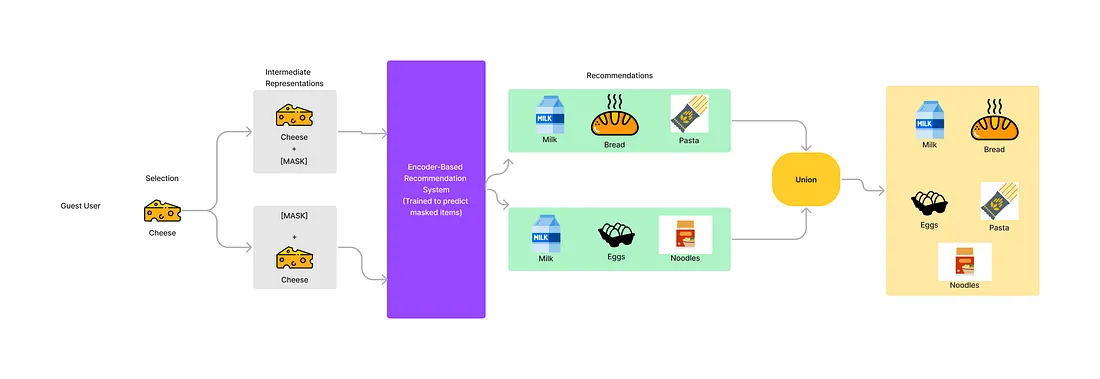
Image source: https://medium.com/geekculture/transformer-based-recommendation-system-b350ef9cb57


-


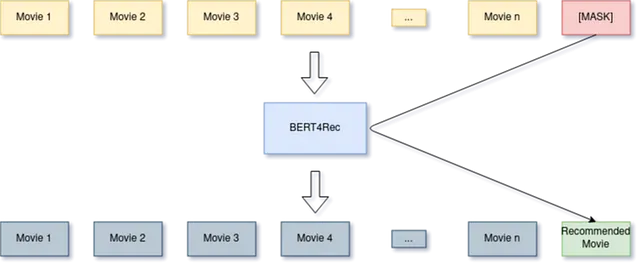
Image source: https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5

In [4]:
pdwm = pd.read_csv('working/playlists_dataset_with_mood.csv')

### Data Pre-processing

In [5]:
pdwm = pdwm.reset_index(drop=True)

mean_popularity = pdwm['track_popularity'].mean()
pdwm.loc[:, 'track_popularity'] = pdwm['track_popularity'].fillna(mean_popularity)

pdwm.loc[:, 'track_explicit'] = pdwm['track_explicit'].fillna(False)

pdwm.loc[:, 'track_explicit'] = pdwm['track_explicit'].astype(int)

In [6]:
pdwm = pdwm.drop(columns=[
    'pos', 'name', 'description', 'modified_at', 'num_tracks','num_albums','num_followers',
    'num_edits', 'artist_name', 'track_name','album_name', 'album_release_date', 'mood',
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'track_popularity', 'track_explicit'
])

[codecarbon INFO @ 18:46:37] Energy consumed for RAM : 0.000101 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:46:37] Energy consumed for all CPUs : 0.000366 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:46:37] 0.000467 kWh of electricity used since the begining.


In [7]:
pdwm_train, pdwm_test = train_test_split(pdwm, test_size=0.2, shuffle=True, random_state=12)

In [8]:
songIdMapping = {k:i+2 for i, k in enumerate(sorted(list(pdwm_train.track_uri.unique())))}

In [9]:
print(len(songIdMapping))

print(max(songIdMapping.keys()))
print(min(songIdMapping.keys()))

print(max(songIdMapping.values()))
print(min(songIdMapping.values()))

233335
7zzbfi8fvHe6hm342GcNYl
000DxekYYbIcxyi3bMAWRP
233336
2


In [10]:
pdwm_train.loc[:, 'songIDmapped'] = pdwm_train['track_uri'].map(songIdMapping)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [11]:
grp_by_train = pdwm.groupby(by="pid")
grp_by_train

In [12]:
random.sample(list(grp_by_train.groups), k=10)

[107420, 308486, 834432, 82150, 245842, 82880, 282958, 694149, 64875, 485076]

In [13]:
pdwm_train

,pid,track_uri,songIDmapped
1120171,631917,4Ki2zXoAdjI74zPeJvUTHS,129728
574987,282640,60xaS8mYBKUW4VQQ666N0T,180348
162177,82467,7zkLpY72g6lKQbiHDqri1S,233198
1006985,574149,0bXpmJyHHYPk6QBFj25bYF,18115
1200092,834127,6g1NlCpW7fgqDnWbCCDrHl,200119
...,...,...,...
1245462,834778,343YBumqHu19cGoGARUTsd,91707
206083,107123,7cMCc8S3GIXRzQRuw49Xol,221977
36482,11570,278LaQLY66cueqPhdOxGUo,63180
564465,282477,69bDRy5MeWQl1lNeEJQIBE,184469


## BERT4Rec 

In [14]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from typing import Optional
import torch.nn as nn
from torch.nn import Linear
from torch.nn import functional as F

In [15]:
PAD = 0
MASK = 1

def mask_list(l1, p=0.8):
    """
    Masks elements in a list based on a given probability.

    Parameters:
        l1 (list): The input list.
        p (float): The probability of masking an element.

    Returns:
        list: The masked list.
    """

    l1 = [a if random.random() < p else MASK for a in l1]
    return l1


def mask_last_elements_list(l1, val_context_size: int = 5):
    """
    Masks the last elements of a list.

    Parameters:
        l1 (list): The input list.
        val_context_size (int): The number of elements to mask from the end.

    Returns:
        list: The list with masked elements.
    """

    l1 = l1[:-val_context_size] + mask_list(l1[-val_context_size:], p=0.5)
    return l1


class Dataset(torch.utils.data.Dataset):
    """
    Custom dataset class for training/validation samples.
    """
    def __init__(self, groups, grp_by, split, history_size=120):
        self.groups = groups
        self.grp_by = grp_by
        self.split = split
        self.history_size = history_size

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = self.groups[idx]

        df = self.grp_by.get_group(group)

        context = get_context(df, split=self.split, context_size=self.history_size)

        trg_items = context["songIDmapped"].tolist()

        if self.split == "train":
            src_items = mask_list(trg_items)
        else:
            src_items = mask_last_elements_list(trg_items)

        pad_mode = "left" if random.random() < 0.5 else "right"
        trg_items = pad_list(trg_items, history_size=self.history_size, mode=pad_mode)
        src_items = pad_list(src_items, history_size=self.history_size, mode=pad_mode)

        src_items = torch.tensor(src_items, dtype=torch.long)

        trg_items = torch.tensor(trg_items, dtype=torch.long)

        return src_items, trg_items
    

def get_context(df: pd.DataFrame, split: str, context_size: int = 120, val_context_size: int = 5):
    """
    Creates training/validation samples.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        split (str): The split (train/val/test).
        context_size (int): The size of the context.
        val_context_size (int): The number of elements in the validation context.

    Returns:
        pd.DataFrame: The context DataFrame.
    """
    if split == "train":
        max_end_index = df.shape[0] - val_context_size
        if max_end_index >= 10:
            end_index = random.randint(10, max_end_index)
        else:
            end_index = df.shape[0]
    elif split in ["val", "test"]:
        end_index = df.shape[0]
    else:
        raise ValueError

    start_index = max(0, end_index - context_size)

    context = df[start_index:end_index]

    return context


def pad_list(list_integers, history_size: int, pad_val: int = PAD, mode="left"):
    """
    Pads a list of integers to a specified length.

    Parameters:
        list_integers (list): The input list of integers.
        history_size (int): The desired length of the padded list.
        pad_val (int): The value used for padding.
        mode (str): The padding mode ("left" or "right").

    Returns:
        list: The padded list of integers.
    """

    if len(list_integers) < history_size:
        if mode == "left":
            list_integers = [pad_val] * (history_size - len(list_integers)) + list_integers
        else:
            list_integers = list_integers + [pad_val] * (history_size - len(list_integers))

    return list_integers

In [16]:
def masked_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor):
    """
    Computes the accuracy of predicted values, considering a mask.

    Parameters:
        y_pred (torch.Tensor): The predicted values.
        y_true (torch.Tensor): The true values.
        mask (torch.Tensor): The mask indicating which values to consider.

    Returns:
        torch.Tensor: The masked accuracy.
    """

    _, predicted = torch.max(y_pred, 1)
    y_true = torch.masked_select(y_true, mask)
    predicted = torch.masked_select(predicted, mask)
    acc = (y_true == predicted).double().mean()
    return acc


def masked_ce(y_pred, y_true, mask):
    """
    Computes the masked cross-entropy loss.

    Parameters:
        y_pred (torch.Tensor): The predicted values.
        y_true (torch.Tensor): The true values.
        mask (torch.Tensor): The mask indicating which values to consider.

    Returns:
        torch.Tensor: The masked cross-entropy loss.
    """

    loss = F.cross_entropy(y_pred, y_true, reduction="none")
    loss = loss * mask
    return loss.sum() / (mask.sum() + 1e-8)

In [17]:
class Recommender(pl.LightningModule):
    def __init__(
        self,
        vocab_size,
        channels=128,
        cap=0,
        mask=1,
        dropout=0.4,
        lr=1e-4,
    ):
        """
        LightningModule for a recommendation model.

        Parameters:
            vocab_size (int): The size of the vocabulary.
            channels (int): The number of channels for item embeddings (default: 128).
            cap (int): Cap parameter (default: 0).
            mask (int): Mask parameter (default: 1).
            dropout (float): Dropout probability (default: 0.4).
            lr (float): Learning rate (default: 1e-4).
        """
        super().__init__()

        self.cap = cap
        self.mask = mask
        self.lr = lr
        self.dropout = dropout
        self.vocab_size = vocab_size

        self.item_embeddings = torch.nn.Embedding(
            self.vocab_size, embedding_dim=channels)

        self.input_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels, nhead=4, dropout=self.dropout)

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.linear_out = Linear(channels, self.vocab_size)

        self.do = nn.Dropout(p=self.dropout)

    def encode_src(self, src_items):
        """
        Encode the source items using embeddings and positional encodings.

        Parameters:
            src_items (torch.Tensor): The source items.

        Returns:
            torch.Tensor: The encoded source items.
        """
        src_items = self.item_embeddings(src_items)

        batch_size, in_sequence_len = src_items.size(0), src_items.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src_items.device)
            .unsqueeze(0)
            .repeat(batch_size, 1))
        pos_encoder = self.input_pos_embedding(pos_encoder)

        src_items += pos_encoder
        src = src_items.permute(1, 0, 2)
        src = self.encoder(src)
        return src.permute(1, 0, 2)

    def forward(self, src_items):
        """
        Forward pass of the recommender model.

        Parameters:
            src_items (torch.Tensor): The source items.

        Returns:
            torch.Tensor: The predicted outputs.
        """

        src = self.encode_src(src_items)
        out = self.linear_out(src)
        return out

    def training_step(self, batch, batch_idx):
        """
        Training step of the recommender model.

        Parameters:
            batch: The batch of data.
            batch_idx (int): Index of the current batch.

        Returns:
            torch.Tensor: The computed loss.
        """
        src_items, y_true = batch

        y_pred = self(src_items)
        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)
        
        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step of the recommender model.

        Parameters:
            batch: The batch of data.
            batch_idx (int): Index of the current batch.

        Returns:
            torch.Tensor: The computed loss.
        """
        src_items, y_true = batch

        y_pred = self(src_items)

        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)

        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)

        self.log("valid_loss", loss)
        self.log("valid_accuracy", accuracy)

        return loss

    def test_step(self, batch, batch_idx):
        """
        Test step of the recommender model.

        Parameters:
            batch: The batch of data.
            batch_idx (int): Index of the current batch.

        Returns:
            torch.Tensor: The computed loss.
        """
        src_items, y_true = batch

        y_pred = self(src_items)

        y_pred = y_pred.view(-1, y_pred.size(2))
        y_true = y_true.view(-1)

        src_items = src_items.view(-1)
        mask = src_items == self.mask

        loss = masked_ce(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)

        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)

        return loss

    def configure_optimizers(self):
        """
        Configure the optimizer and learning rate scheduler.

        Returns:
            dict: Dictionary containing the optimizer, learning rate scheduler, and monitoring metric.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "valid_loss",
        }

In [18]:
def train(data, mapping,
    log_dir: str = "models/BERT/recommender_logs",
    model_dir: str = "models/BERT/recommender_models",
    batch_size: int = 32,
    epochs: int = 2000,
    history_size: int = 120):
    """
    Train the recommender model.

    Parameters:
        data: The input data.
        mapping: Mapping of tokens to indices.
        log_dir (str): Directory to save the training logs.
        model_dir (str): Directory to save the trained models.
        batch_size (int): Size of each training batch.
        epochs (int): Number of training epochs.
        history_size (int): Size of the history/context.

    Returns:
        None
    """

    grp_by_train = data.groupby(by="pid")

    groups = list(grp_by_train.groups)

    train_data = Dataset(
        groups=groups,
        grp_by=grp_by_train,
        split="train",
        history_size=history_size,
    )
    val_data = Dataset(
        groups=groups,
        grp_by=grp_by_train,
        split="val",
        history_size=history_size,
    )

    print("len(train_data)", len(train_data))
    print("len(val_data)", len(val_data))

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=5,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=5,
        shuffle=False,
    )

    model = Recommender(
        vocab_size=len(mapping) + 2,
        lr=1e-4,
        dropout=0.3,
    )

    logger = TensorBoardLogger(
        save_dir=log_dir,
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="valid_loss",
        mode="min",
        dirpath=model_dir,
        filename="recommender",
    )

    trainer = pl.Trainer(
        max_epochs=epochs,
        logger=logger,
        callbacks=[checkpoint_callback],
    )
    trainer.fit(model, train_loader, val_loader)

    return

In [175]:
train(data=pdwm_train, mapping=songIdMapping, epochs=10)

len(train_data) 20000
len(val_data) 20000


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/asadcor/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/asadcor/models/BERT/recommender_models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name                | Type               | Params
-----------------------------------------------------------
0 | item_embeddings     | Embedding          | 29.9 M
1 | input_pos_embedding | Embedding          | 65.5 K
2 | encoder             | TransformerEncoder | 3.6 M 
3 | linear_out          | Linear             | 30.1 M
4 | do                  | Dropout            | 0     
-----------------------------------------------------------
63.6 M    Trainable params
0         Non-trainable params
63.6 M    Total params
254.365   Total estimated model params size 

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:25<00:00,  5.13s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  16%|██████████████▋                                                                                | 97/625 [03:18<18:01,  2.05s/it]


Validation DataLoader 0:  32%|█████████████████████████████▋                                                                | 197/625 [06:43<14:35,  2.05s/it]


Validation DataLoader 0:  48%|████████████████████████████████████████████▋                                                 | 297/625 [10:09<11:12,  2.05s/it]


Validation DataLoader 0:  64%|███████████████████████████████████████████████████████████▋                                  | 397/625 [13:36<07:48,  2.06s/it]


Validation DataLoader 0:  80%|██████████████████████████████████████████████████████████████████████████▋                   | 497/625 [17:01<04:23,  2.06s/it]


Validation DataLoader 0:  96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 597/625 [20:27<00:57,  2.06s/it]


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [52:22<00:00,  5.03s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  11%|██████████▍                                                                                    | 69/625 [02:21<19:00,  2.05s/it]


Validation DataLoader 0:  27%|█████████████████████████▋                                                                    | 171/625 [05:53<15:37,  2.07s/it]


Validation DataLoader 0:  43%|████████████████████████████████████████▊                                                     | 271/625 [09:18<12:09,  2.06s/it]


Validation DataLoader 0:  59%|███████████████████████████████████████████████████████▊                                      | 371/625 [12:43<08:42,  2.06s/it]


Validation DataLoader 0:  76%|███████████████████████████████████████████████████████████████████████▏                      | 473/625 [16:12<05:12,  2.06s/it]


Validation DataLoader 0:  92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 573/625 [19:37<01:46,  2.05s/it]


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [52:59<00:00,  5.09s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   7%|██████▊                                                                                        | 45/625 [01:33<20:00,  2.07s/it]


Validation DataLoader 0:  23%|█████████████████████▊                                                                        | 145/625 [05:00<16:34,  2.07s/it]


Validation DataLoader 0:  39%|████████████████████████████████████▊                                                         | 245/625 [08:28<13:08,  2.07s/it]


Validation DataLoader 0:  55%|███████████████████████████████████████████████████▉                                          | 345/625 [11:54<09:39,  2.07s/it]


Validation DataLoader 0:  71%|██████████████████████████████████████████████████████████████████▉                           | 445/625 [15:21<06:12,  2.07s/it]


Validation DataLoader 0:  87%|█████████████████████████████████████████████████████████████████████████████████▉            | 545/625 [18:48<02:45,  2.07s/it]


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [52:56<00:00,  5.08s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   3%|██▌                                                                                            | 17/625 [00:35<20:58,  2.07s/it]


Validation DataLoader 0:  19%|█████████████████▌                                                                            | 117/625 [04:00<17:24,  2.06s/it]


Validation DataLoader 0:  35%|████████████████████████████████▋                                                             | 217/625 [07:25<13:58,  2.05s/it]


Validation DataLoader 0:  51%|███████████████████████████████████████████████▋                                              | 317/625 [10:52<10:34,  2.06s/it]


Validation DataLoader 0:  67%|██████████████████████████████████████████████████████████████▋                               | 417/625 [14:19<07:08,  2.06s/it]


Validation DataLoader 0:  83%|█████████████████████████████████████████████████████████████████████████████▊                | 517/625 [17:44<03:42,  2.06s/it]


Validation DataLoader 0:  99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 617/625 [21:11<00:16,  2.06s/it]


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:06<00:00,  5.10s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  14%|█████████████▌                                                                                 | 89/625 [03:04<18:31,  2.07s/it]


Validation DataLoader 0:  30%|████████████████████████████▍                                                                 | 189/625 [06:32<15:04,  2.08s/it]


Validation DataLoader 0:  46%|███████████████████████████████████████████▍                                                  | 289/625 [10:00<11:37,  2.08s/it]


Validation DataLoader 0:  62%|██████████████████████████████████████████████████████████▌                                   | 389/625 [13:28<08:10,  2.08s/it]


Validation DataLoader 0:  78%|█████████████████████████████████████████████████████████████████████████▌                    | 489/625 [16:56<04:42,  2.08s/it]


Validation DataLoader 0:  94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 589/625 [20:26<01:14,  2.08s/it]


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:36<00:00,  5.15s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  10%|█████████▌                                                                                     | 63/625 [02:10<19:20,  2.06s/it]


Validation DataLoader 0:  26%|████████████████████████▌                                                                     | 163/625 [05:37<15:57,  2.07s/it]


Validation DataLoader 0:  42%|███████████████████████████████████████▌                                                      | 263/625 [09:05<12:31,  2.08s/it]


Validation DataLoader 0:  58%|██████████████████████████████████████████████████████▌                                       | 363/625 [12:33<09:04,  2.08s/it]


Validation DataLoader 0:  74%|█████████████████████████████████████████████████████████████████████▋                        | 463/625 [16:02<05:36,  2.08s/it]


Validation DataLoader 0:  90%|████████████████████████████████████████████████████████████████████████████████████▉         | 565/625 [19:34<02:04,  2.08s/it]


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:01<00:00,  5.09s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   6%|█████▌                                                                                         | 37/625 [01:16<20:23,  2.08s/it]


Validation DataLoader 0:  22%|████████████████████▌                                                                         | 137/625 [04:44<16:53,  2.08s/it]


Validation DataLoader 0:  38%|███████████████████████████████████▋                                                          | 237/625 [08:11<13:24,  2.07s/it]


Validation DataLoader 0:  54%|██████████████████████████████████████████████████▋                                           | 337/625 [11:38<09:57,  2.07s/it]


Validation DataLoader 0:  70%|█████████████████████████████████████████████████████████████████▋                            | 437/625 [15:05<06:29,  2.07s/it]


Validation DataLoader 0:  86%|████████████████████████████████████████████████████████████████████████████████▊             | 537/625 [18:33<03:02,  2.07s/it]


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:19<00:00,  5.12s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   1%|█▍                                                                                              | 9/625 [00:18<21:34,  2.10s/it]


Validation DataLoader 0:  17%|████████████████▍                                                                             | 109/625 [03:47<17:54,  2.08s/it]


Validation DataLoader 0:  33%|███████████████████████████████▍                                                              | 209/625 [07:16<14:29,  2.09s/it]


Validation DataLoader 0:  49%|██████████████████████████████████████████████▍                                               | 309/625 [10:44<10:59,  2.09s/it]


Validation DataLoader 0:  65%|█████████████████████████████████████████████████████████████▌                                | 409/625 [14:14<07:31,  2.09s/it]


Validation DataLoader 0:  81%|████████████████████████████████████████████████████████████████████████████▌                 | 509/625 [17:43<04:02,  2.09s/it]


Validation DataLoader 0:  97%|███████████████████████████████████████████████████████████████████████████████████████████▌  | 609/625 [21:12<00:33,  2.09s/it]


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:28<00:00,  5.13s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  13%|████████████▎                                                                                  | 81/625 [02:49<18:56,  2.09s/it]


Validation DataLoader 0:  29%|███████████████████████████▏                                                                  | 181/625 [06:19<15:29,  2.09s/it]


Validation DataLoader 0:  45%|██████████████████████████████████████████▎                                                   | 281/625 [09:47<11:59,  2.09s/it]


Validation DataLoader 0:  61%|█████████████████████████████████████████████████████████▎                                    | 381/625 [13:15<08:29,  2.09s/it]


Validation DataLoader 0:  77%|████████████████████████████████████████████████████████████████████████▎                     | 481/625 [16:43<05:00,  2.09s/it]


Validation DataLoader 0:  93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 581/625 [20:11<01:31,  2.09s/it]


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [53:42<00:00,  5.16s/it, v_num=11]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   8%|████████                                                                                       | 53/625 [01:51<20:01,  2.10s/it]


Validation DataLoader 0:  24%|███████████████████████                                                                       | 153/625 [05:19<16:26,  2.09s/it]


Validation DataLoader 0:  40%|██████████████████████████████████████                                                        | 253/625 [08:49<12:58,  2.09s/it]


Validation DataLoader 0:  56%|█████████████████████████████████████████████████████                                         | 353/625 [12:19<09:29,  2.10s/it]


Validation DataLoader 0:  72%|████████████████████████████████████████████████████████████████████▏                         | 453/625 [15:50<06:00,  2.10s/it]


Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████████▏          | 553/625 [19:18<02:30,  2.10s/it]


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [1:15:33<00:00,  7.25s/it, v_num=11]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [1:15:33<00:00,  7.25s/it, v_num=11]


In [19]:
model_path = "models/BERT/recommender_models/recommender-v1.ckpt"

model = Recommender(
        vocab_size=len(songIdMapping) + 2,
        lr=1e-4,
        dropout=0.3,
    )
model.eval()
model.load_state_dict(torch.load(model_path)["state_dict"])

[codecarbon INFO @ 18:46:52] Energy consumed for RAM : 0.000150 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:46:52] Energy consumed for all CPUs : 0.000543 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:46:52] 0.000693 kWh of electricity used since the begining.


<All keys matched successfully>

In [20]:
model

Recommender(
  (item_embeddings): Embedding(233337, 128)
  (input_pos_embedding): Embedding(512, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (linear_out): Linear(in_features=128, out_features=233337, bias=True)
  (do): Dropout(p=0.3, inplace=False)
)

### Prediction

In [21]:
songIdMapping_ = {k:i+2 for i, k in enumerate(sorted(list(pdwm_test.track_uri.unique())))}

test_to_idx = {b: songIdMapping_[b] for b in pdwm_test.track_uri.tolist() if b in songIdMapping_}
idx_to_test = {v: k for k, v in test_to_idx.items()}

[codecarbon INFO @ 18:47:07] Energy consumed for RAM : 0.000199 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:47:07] Energy consumed for all CPUs : 0.000720 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:47:07] 0.000919 kWh of electricity used since the begining.
[codecarbon INFO @ 18:47:22] Energy consumed for RAM : 0.000248 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:47:22] Energy consumed for all CPUs : 0.000897 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:47:22] 0.001145 kWh of electricity used since the begining.


In [22]:
def predict(list_to_predict, model, _to_idx, idx_to_):
    """
    Generate predictions for a given list of items using the model.

    Parameters:
        list_to_predict (list): List of items to predict.
        model: The trained model.
        _to_idx: Mapping of tokens to indices.
        idx_to_: Mapping of indices to tokens.

    Returns:
        predicted_items (list): List of predicted items.
    """
    ids = [PAD] * (120 - len(list_to_predict) - 1) + [_to_idx[a] for a in list_to_predict] + [MASK]
    src = torch.tensor(ids, dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        prediction = model(src)
    
    masked_pred = prediction[0, -1].numpy()
    sorted_predicted_ids = np.argsort(masked_pred).tolist()[::-1]
    sorted_predicted_ids = [a for a in sorted_predicted_ids if a not in ids]

    return [idx_to_[a] for a in sorted_predicted_ids[:4] if a in idx_to_]

[codecarbon INFO @ 18:47:37] Energy consumed for RAM : 0.000297 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:47:37] Energy consumed for all CPUs : 0.001074 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:47:37] 0.001371 kWh of electricity used since the begining.


#### Example of prediction

In [23]:
predict(['2cGxRwrMyEAp8dEbuZaVv6', '6y5Y11726SHrs5Uc30n5pB'], model, test_to_idx, idx_to_test)

['2OIDBEMxr6ViaAYteOQqmC']

### Predicting data

In [54]:
songIdMapping_ = {k:i+2 for i, k in enumerate(sorted(list(pdwm_100k_filtered.track_uri.unique())))}

test_to_idx = {b: songIdMapping_[b] for b in pdwm_100k_filtered.track_uri.tolist() if b in songIdMapping_}
idx_to_test = {v: k for k, v in test_to_idx.items()}

In [30]:
def predict(list_to_predict, model, _to_idx, idx_to_, num_predictions=4):
    """
    Generate predictions for a given list of items using the model.

    Parameters:
        list_to_predict (list): List of items to predict.
        model: The trained model.
        _to_idx: Mapping of tokens to indices.
        idx_to_: Mapping of indices to tokens.

    Returns:
        predicted_items (list): List of predicted items.
    """
    ids = [PAD] * (120 - len(list_to_predict) - 1) + [_to_idx[a] for a in list_to_predict] + [MASK]
    src = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    with torch.no_grad():
        prediction = model(src)
    masked_pred = prediction[0, -1].numpy()
    sorted_predicted_ids = np.argsort(masked_pred).tolist()[::-1]
    sorted_predicted_ids = [a for a in sorted_predicted_ids if a not in ids]
    return [idx_to_[a] for a in sorted_predicted_ids[:num_predictions*10] if a in idx_to_]

In [31]:
%%time

playlist_tracks = pdwm_100k_filtered.groupby('pid')['track_uri'].apply(list)

# define a function to remove 80% of the tracks in each playlist and predict the rest
def predict_remaining_tracks(tracks, model, to_idx, idx_to):
    """
    Predict the remaining tracks in a given list using the model.

    Parameters:
        tracks (list): List of tracks.
        model: The trained model.
        to_idx: Mapping of tokens to indices.
        idx_to: Mapping of indices to tokens.

    Returns:
        predicted_items (list): List of predicted items for the remaining tracks.
    """
    num_tracks = len(tracks)
    num_tracks_to_remove = int(num_tracks * 0.8)
    remaining_tracks = tracks[num_tracks_to_remove:]
    return predict(remaining_tracks, model, to_idx, idx_to)

# create a dictionary to store the predictions for each playlist
predictions = {}

for pid, tracks in playlist_tracks.items():
    predictions[pid] = predict_remaining_tracks(tracks, model, test_to_idx, idx_to_test)

[codecarbon INFO @ 18:55:23] Energy consumed for RAM : 0.001820 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:55:23] Energy consumed for all CPUs : 0.006578 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:55:23] 0.008398 kWh of electricity used since the begining.
[codecarbon INFO @ 18:55:38] Energy consumed for RAM : 0.001869 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:55:38] Energy consumed for all CPUs : 0.006756 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:55:38] 0.008624 kWh of electricity used since the begining.
[codecarbon INFO @ 18:55:53] Energy consumed for RAM : 0.001917 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:55:53] Energy consumed for all CPUs : 0.006933 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:55:53] 0.008850 kWh of electricity used since the begining.
[codecarbon INFO @ 18:56:08] Energy consumed for RAM : 0.001966 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:56:08] Energy consumed for all

[codecarbon INFO @ 19:02:38] Energy consumed for all CPUs : 0.011711 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:02:38] 0.014947 kWh of electricity used since the begining.
[codecarbon INFO @ 19:02:53] Energy consumed for RAM : 0.003285 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:02:53] Energy consumed for all CPUs : 0.011887 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:02:53] 0.015172 kWh of electricity used since the begining.
[codecarbon INFO @ 19:03:08] Energy consumed for RAM : 0.003334 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:03:08] Energy consumed for all CPUs : 0.012064 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:03:08] 0.015398 kWh of electricity used since the begining.
[codecarbon INFO @ 19:03:23] Energy consumed for RAM : 0.003383 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:03:23] Energy consumed for all CPUs : 0.012241 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:03:23] 0.015623 kWh of electricity

[codecarbon INFO @ 19:09:54] 0.021494 kWh of electricity used since the begining.
[codecarbon INFO @ 19:10:09] Energy consumed for RAM : 0.004702 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:10:09] Energy consumed for all CPUs : 0.017018 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:10:09] 0.021720 kWh of electricity used since the begining.
[codecarbon INFO @ 19:10:24] Energy consumed for RAM : 0.004751 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:10:24] Energy consumed for all CPUs : 0.017195 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:10:24] 0.021946 kWh of electricity used since the begining.
[codecarbon INFO @ 19:10:39] Energy consumed for RAM : 0.004800 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:10:39] Energy consumed for all CPUs : 0.017372 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:10:39] 0.022173 kWh of electricity used since the begining.
[codecarbon INFO @ 19:10:54] Energy consumed for RAM : 0.004849 kWh. RAM

[codecarbon INFO @ 19:17:24] Energy consumed for RAM : 0.006120 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:24] Energy consumed for all CPUs : 0.022149 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:24] 0.028269 kWh of electricity used since the begining.
[codecarbon INFO @ 19:17:39] Energy consumed for RAM : 0.006168 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:39] Energy consumed for all CPUs : 0.022325 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:39] 0.028494 kWh of electricity used since the begining.
[codecarbon INFO @ 19:17:54] Energy consumed for RAM : 0.006217 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:17:54] Energy consumed for all CPUs : 0.022502 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:17:54] 0.028720 kWh of electricity used since the begining.
[codecarbon INFO @ 19:18:09] Energy consumed for RAM : 0.006266 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:18:09] Energy consumed for all

[codecarbon INFO @ 19:24:39] Energy consumed for all CPUs : 0.027279 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:39] 0.034815 kWh of electricity used since the begining.
[codecarbon INFO @ 19:24:54] Energy consumed for RAM : 0.007585 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:24:54] Energy consumed for all CPUs : 0.027456 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:24:54] 0.035041 kWh of electricity used since the begining.
[codecarbon INFO @ 19:25:09] Energy consumed for RAM : 0.007634 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:09] Energy consumed for all CPUs : 0.027634 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:09] 0.035267 kWh of electricity used since the begining.
[codecarbon INFO @ 19:25:24] Energy consumed for RAM : 0.007683 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:25:24] Energy consumed for all CPUs : 0.027810 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:25:24] 0.035493 kWh of electricity

[codecarbon INFO @ 19:31:54] 0.041366 kWh of electricity used since the begining.
[codecarbon INFO @ 19:32:09] Energy consumed for RAM : 0.009003 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:09] Energy consumed for all CPUs : 0.032589 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:09] 0.041592 kWh of electricity used since the begining.
[codecarbon INFO @ 19:32:24] Energy consumed for RAM : 0.009052 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:24] Energy consumed for all CPUs : 0.032767 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:24] 0.041819 kWh of electricity used since the begining.
[codecarbon INFO @ 19:32:39] Energy consumed for RAM : 0.009101 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:32:39] Energy consumed for all CPUs : 0.032944 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:32:39] 0.042045 kWh of electricity used since the begining.
[codecarbon INFO @ 19:32:54] Energy consumed for RAM : 0.009150 kWh. RAM

[codecarbon INFO @ 19:39:25] Energy consumed for RAM : 0.010420 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:25] Energy consumed for all CPUs : 0.037720 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:25] 0.048140 kWh of electricity used since the begining.
[codecarbon INFO @ 19:39:40] Energy consumed for RAM : 0.010469 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:40] Energy consumed for all CPUs : 0.037897 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:40] 0.048365 kWh of electricity used since the begining.
[codecarbon INFO @ 19:39:55] Energy consumed for RAM : 0.010518 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:39:55] Energy consumed for all CPUs : 0.038073 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:39:55] 0.048591 kWh of electricity used since the begining.
[codecarbon INFO @ 19:40:10] Energy consumed for RAM : 0.010566 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:40:10] Energy consumed for all

[codecarbon INFO @ 19:46:40] Energy consumed for all CPUs : 0.042848 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:46:40] 0.054683 kWh of electricity used since the begining.
[codecarbon INFO @ 19:46:55] Energy consumed for RAM : 0.011884 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:46:55] Energy consumed for all CPUs : 0.043024 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:46:55] 0.054908 kWh of electricity used since the begining.
[codecarbon INFO @ 19:47:10] Energy consumed for RAM : 0.011933 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:47:10] Energy consumed for all CPUs : 0.043201 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:47:10] 0.055134 kWh of electricity used since the begining.
[codecarbon INFO @ 19:47:25] Energy consumed for RAM : 0.011982 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:47:25] Energy consumed for all CPUs : 0.043377 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:47:25] 0.055359 kWh of electricity

[codecarbon INFO @ 19:53:55] 0.061231 kWh of electricity used since the begining.
[codecarbon INFO @ 19:54:10] Energy consumed for RAM : 0.013301 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:54:10] Energy consumed for all CPUs : 0.048156 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:54:10] 0.061457 kWh of electricity used since the begining.
[codecarbon INFO @ 19:54:25] Energy consumed for RAM : 0.013350 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:54:25] Energy consumed for all CPUs : 0.048334 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:54:25] 0.061684 kWh of electricity used since the begining.
[codecarbon INFO @ 19:54:40] Energy consumed for RAM : 0.013399 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 19:54:40] Energy consumed for all CPUs : 0.048510 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 19:54:40] 0.061909 kWh of electricity used since the begining.
[codecarbon INFO @ 19:54:55] Energy consumed for RAM : 0.013448 kWh. RAM

[codecarbon INFO @ 20:01:25] Energy consumed for RAM : 0.014718 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:01:25] Energy consumed for all CPUs : 0.053286 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:01:25] 0.068004 kWh of electricity used since the begining.
[codecarbon INFO @ 20:01:40] Energy consumed for RAM : 0.014767 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:01:40] Energy consumed for all CPUs : 0.053463 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:01:40] 0.068230 kWh of electricity used since the begining.
[codecarbon INFO @ 20:01:55] Energy consumed for RAM : 0.014816 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:01:55] Energy consumed for all CPUs : 0.053640 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:01:55] 0.068456 kWh of electricity used since the begining.
[codecarbon INFO @ 20:02:10] Energy consumed for RAM : 0.014865 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:02:10] Energy consumed for all

[codecarbon INFO @ 20:08:41] Energy consumed for all CPUs : 0.058417 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:08:41] 0.074552 kWh of electricity used since the begining.
[codecarbon INFO @ 20:08:56] Energy consumed for RAM : 0.016184 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:08:56] Energy consumed for all CPUs : 0.058594 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:08:56] 0.074778 kWh of electricity used since the begining.
[codecarbon INFO @ 20:09:11] Energy consumed for RAM : 0.016233 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:09:11] Energy consumed for all CPUs : 0.058771 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:09:11] 0.075004 kWh of electricity used since the begining.
[codecarbon INFO @ 20:09:26] Energy consumed for RAM : 0.016282 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:09:26] Energy consumed for all CPUs : 0.058949 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:09:26] 0.075231 kWh of electricity

CPU times: user 2h 29min 2s, sys: 10.8 s, total: 2h 29min 13s
Wall time: 1h 17min 3s


[codecarbon INFO @ 20:12:26] Energy consumed for RAM : 0.016869 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:12:26] Energy consumed for all CPUs : 0.061072 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:12:26] 0.077940 kWh of electricity used since the begining.
[codecarbon INFO @ 20:12:41] Energy consumed for RAM : 0.016918 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:12:41] Energy consumed for all CPUs : 0.061249 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:12:41] 0.078166 kWh of electricity used since the begining.
[codecarbon INFO @ 20:12:56] Energy consumed for RAM : 0.016967 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:12:56] Energy consumed for all CPUs : 0.061426 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:12:56] 0.078392 kWh of electricity used since the begining.


In [32]:
# Convert the dictionary to a dataframe
pred_data = pd.DataFrame([(k, v) for k, vs in predictions.items() for v in vs], columns=['pid', 'track_uri'])

[codecarbon INFO @ 20:13:11] Energy consumed for RAM : 0.017016 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:13:11] Energy consumed for all CPUs : 0.061603 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:13:11] 0.078619 kWh of electricity used since the begining.


In [33]:
pred_data.to_csv('working/pred_data.csv', index= False)

#### Preprocessing data for metrics

In [25]:
import scipy.sparse as sp
from scipy.sparse import csr_matrix

In [26]:
%%time

pdwm_test_100k = pdwm_test.sample(n=80000, random_state=12)

mask = pdwm_test_100k['pid'].duplicated(keep=False)
pdwm_100k_filtered = pdwm_test_100k[mask]


# Create Binary Sparse Matrix
s_matrix = pd.crosstab(pdwm_100k_filtered.pid, pdwm_100k_filtered.track_uri)
s_matrix = s_matrix.clip(upper=1)

assert np.max(s_matrix.describe().loc['max']) == 1

sparse_matrix = csr_matrix(s_matrix, dtype=np.float64)

[codecarbon INFO @ 18:48:23] Energy consumed for RAM : 0.000448 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:48:23] Energy consumed for all CPUs : 0.001621 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:48:23] 0.002069 kWh of electricity used since the begining.
[codecarbon INFO @ 18:48:38] Energy consumed for RAM : 0.000497 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:48:38] Energy consumed for all CPUs : 0.001798 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:48:38] 0.002295 kWh of electricity used since the begining.
[codecarbon INFO @ 18:48:53] Energy consumed for RAM : 0.000546 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:48:53] Energy consumed for all CPUs : 0.001975 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:48:53] 0.002521 kWh of electricity used since the begining.
[codecarbon INFO @ 18:49:08] Energy consumed for RAM : 0.000595 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:49:08] Energy consumed for all

CPU times: user 3min 15s, sys: 23.4 s, total: 3min 38s
Wall time: 3min 38s


In [27]:
sparse_matrix_csv = sparse_matrix.tocsc()
pdwm_100k_values = sparse_matrix_csv.toarray().reshape(-1,)

[codecarbon INFO @ 18:52:08] Energy consumed for RAM : 0.001183 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:52:08] Energy consumed for all CPUs : 0.004276 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:52:08] 0.005459 kWh of electricity used since the begining.
[codecarbon INFO @ 18:52:23] Energy consumed for RAM : 0.001232 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:52:23] Energy consumed for all CPUs : 0.004453 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:52:23] 0.005685 kWh of electricity used since the begining.
[codecarbon INFO @ 18:52:38] Energy consumed for RAM : 0.001281 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:52:38] Energy consumed for all CPUs : 0.004630 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:52:38] 0.005911 kWh of electricity used since the begining.
[codecarbon INFO @ 18:52:53] Energy consumed for RAM : 0.001330 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 18:52:53] Energy consumed for all

Predicted

In [38]:
%%time

# Create Binary Sparse Matrix
ps_matrix = pd.crosstab(pred_data.pid, pred_data.track_uri)
ps_matrix = ps_matrix.clip(upper=1)

psparse_matrix = csr_matrix(ps_matrix, dtype=np.float64)

CPU times: user 70.6 ms, sys: 12 ms, total: 82.7 ms
Wall time: 81.7 ms


[codecarbon INFO @ 20:14:41] Energy consumed for RAM : 0.017309 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:14:41] Energy consumed for all CPUs : 0.062665 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:14:41] 0.079975 kWh of electricity used since the begining.


In [39]:
p_sparse_matrix_csv = psparse_matrix.tocsc()
pred_values = p_sparse_matrix_csv.toarray().reshape(-1,)

### Metrics

In [43]:
import math

In [47]:
rec = np.where(pdwm_100k_values == 1)[0].tolist()
Y = np.where(pred_values == 1)[0].tolist()

In [48]:
def R_precision(rec, Y):
    """
    Computes the R-Precision score for a given recommendation list.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        float: The R-Precision score.

    """
    count = 0
    for song in Y:
        if song in rec[:len(Y)]:
            count += 1 
    return count/len(Y)

def NDCG(rec, Y):
    """
    Computes the Normalized Discounted Cumulative Gain (NDCG) score for a given recommendation list.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        float: The NDCG score.

    """
    IDCG = 0
    for i in range(0,len(Y)):
        if i == 0: IDCG += 1
        else: IDCG += 1/math.log((i+2),2)
    DCG = 0
    for i in range(0,len(rec)):
        if i == 0 and rec[i] in Y: DCG += 1
        elif i > 0 and rec[i] in Y: DCG += 1/math.log((i+2),2)     
    return DCG/IDCG

def clicks(rec, Y):
    """
    Computes the number of recommendations until the first correct recommendation is found.

    Parameters:
        rec (list): The recommendation list.
        Y (list): The ground truth track list.

    Returns:
        int: The number of recommendations until the first correct recommendation is found.

    """
    found_at = -1
    find = 0
    while found_at == -1 and find < len(Y):
        if rec[find] in Y: found_at = find
        else: find += 1
    if found_at == -1:
        return len(Y)//10
    else:
        return found_at//10

In [49]:
R_precision_score = R_precision(rec, Y)
NDCG_score = NDCG(rec, Y)
clicks_score = clicks(rec, Y)

print(f'R_precision: {R_precision_score}')
print(f'NDCG: {NDCG_score}')

print(f'clicks: {clicks_score}')

R_precision: 0.00015755475027572083
NDCG: 0.0008748941890225237
clicks: 0


[codecarbon INFO @ 20:16:11] Energy consumed for RAM : 0.017603 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:16:11] Energy consumed for all CPUs : 0.063728 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:16:11] 0.081331 kWh of electricity used since the begining.
[codecarbon INFO @ 20:16:26] Energy consumed for RAM : 0.017652 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:16:26] Energy consumed for all CPUs : 0.063905 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:16:26] 0.081557 kWh of electricity used since the begining.
[codecarbon INFO @ 20:16:41] Energy consumed for RAM : 0.017701 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:16:41] Energy consumed for all CPUs : 0.064082 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:16:41] 0.081783 kWh of electricity used since the begining.
[codecarbon INFO @ 20:16:56] Energy consumed for RAM : 0.017750 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:16:56] Energy consumed for all

In [50]:
experiment.end()

[codecarbon INFO @ 20:17:50] Energy consumed for RAM : 0.017927 kWh. RAM Power : 11.759872913360596 W
[codecarbon INFO @ 20:17:50] Energy consumed for all CPUs : 0.064896 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 20:17:50] 0.082822 kWh of electricity used since the begining.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/sadcor/general/8cbf32100d564020a5a3bc434383d611
COMET INFO:   Uploads:
COMET INFO:     asset               : 1 (696 bytes)
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code    